In [1]:
!pip install lightfm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.4/316.4 kB 6.0 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for lightfm: filename=lightfm-1.17-cp311-cp311-linux_x86_64.whl size=829227 sha256=786c9d108a1fc15ce1dc585306c8b7c5fab06af2e45636eebc9538d713f8fa11
  Stored in directory: /root/.cache/pip/wheels/b9/0d/8a/0729d2e6e3ca2a898ba55201f905da7db3f838a33df5b3fcdd
Successfully built lightfm


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import warnings
warnings.simplefilter("ignore")
seed = 2354
np.random.seed(seed=seed)

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)

In [3]:
games_df = pd.read_csv("/kaggle/input/game-recommendations-on-steam/games.csv")
users_df = pd.read_csv("/kaggle/input/game-recommendations-on-steam/users.csv")
games_meta_df = pd.read_json("/kaggle/input/game-recommendations-on-steam/games_metadata.json", lines=True)
iteractions_df = pd.read_csv("/kaggle/input/game-recommendations-on-steam/recommendations.csv")

In [4]:
games_meta_df.head()

,app_id,description,tags
0,13500,Enter the dark underworld of Prince of Persia ...,"[Action, Adventure, Parkour, Third Person, Gre..."
1,22364,,[Action]
2,113020,Monaco: What's Yours Is Mine is a single playe...,"[Co-op, Stealth, Indie, Heist, Local Co-Op, St..."
3,226560,Escape Dead Island is a Survival-Mystery adven...,"[Zombies, Adventure, Survival, Action, Third P..."
4,249050,Dungeon of the Endless is a Rogue-Like Dungeon...,"[Roguelike, Strategy, Tower Defense, Pixel Gra..."


# Предобработка

In [5]:
iteractions_df["app_id"].value_counts()

app_id
440        319492
252490     270684
1091500    226414
730        219737
570        216914
            ...  
2217450         1
884400          1
1189190         1
1055950         1
1148080         1
Name: count, Length: 37610, dtype: int64

In [6]:
iteractions_df["app_id"].value_counts().describe()

count     37610.000000
mean       1094.251369
std        7689.340463
min           1.000000
25%          13.000000
50%          39.000000
75%         179.750000
max      319492.000000
Name: count, dtype: float64

In [7]:
temp = iteractions_df["app_id"].value_counts()
filt_index = temp[(temp >= 40) & (temp <= 5000)].index

In [8]:
iteractions_df = iteractions_df[iteractions_df["app_id"].isin(filt_index)]

In [9]:
iteractions_df["date"] = pd.to_datetime(iteractions_df["date"])

In [10]:
max_date = max(iteractions_df["date"])
max_date

Timestamp('2022-12-31 00:00:00')

In [11]:
global_train, global_test = (
    iteractions_df[iteractions_df["date"] < max_date - pd.Timedelta(days=30)]
    ,iteractions_df[iteractions_df["date"] >= max_date - pd.Timedelta(days=30)]
)

In [12]:
lfm_train_threshold = global_train["date"].quantile(q=0.8, interpolation="nearest")
lfm_train_threshold

Timestamp('2022-01-07 00:00:00')

In [13]:
lfm_train = global_train[global_train["date"] < lfm_train_threshold]
lfm_pred = global_train[global_train["date"] >= lfm_train_threshold]

In [14]:
lfm_pred = lfm_pred[lfm_pred["user_id"].isin(lfm_train["user_id"].unique())]

In [15]:
from lightfm.data import Dataset
from lightfm import LightFM

In [16]:
dataset = Dataset()
dataset.fit(lfm_train["user_id"].unique(), lfm_train["app_id"].unique())

In [17]:
iteractions_matrix, weights_matrix = (
    dataset.build_interactions(
        zip(
            *lfm_train[["user_id", "app_id", "is_recommended"]].values.T
        )
    )
)
weights_matrix_csr = weights_matrix.tocsr()

In [18]:
lightfm_mapping = dataset.mapping()
lightfm_mapping = {
    "users_mapping":lightfm_mapping[0]
    ,"apps_mapping":lightfm_mapping[2]
}

In [19]:
lightfm_mapping["users_inv_mapping"] = {v:k for k, v in lightfm_mapping["users_mapping"].items()}
lightfm_mapping["apps_inv_mapping"] = {v:k for k, v in lightfm_mapping["apps_mapping"].items()}

In [20]:
print(len(lightfm_mapping["users_inv_mapping"]))
print(len(lightfm_mapping["apps_inv_mapping"]))

2855118
15659


In [21]:
lfm_model = (
    LightFM(
        no_components = 32
        ,learning_rate = 1e-1
        ,loss="warp"
        ,max_sampled = 5
        ,random_state = seed
    )
)

In [22]:
from tqdm import tqdm

In [23]:
num_epochs = 30

for _ in tqdm(range(num_epochs)):
    lfm_model.fit_partial(weights_matrix_csr)

100%|██████████| 30/30 [04:10<00:00,  8.35s/it]


In [24]:
candidates = pd.DataFrame({"user_id":lfm_pred["user_id"].unique()})

In [25]:
candidates.head()

,user_id
0,11391224
1,11327355
2,3156894
3,5357060
4,13099571


In [26]:
def generate_lightfm_recs_mapper(model, item_ids, known_items, N, 
                                 user_mapping, item_inv_mapping,
                                 user_features=None, item_features=None, 
                                 num_threads=1):
    def _recs_mapper(user):
        user_id = user_mapping[user]
        recs = model.predict(user_id, item_ids, user_features=user_features, 
                             item_features=item_features, num_threads=num_threads)
        
        additional_N = len(known_items[user_id]) if user_id in known_items else 0
        total_N = N + additional_N
        top_cols = np.argpartition(recs, -np.arange(total_N))[-total_N:][::-1]
        
        final_recs = [item_inv_mapping[item] for item in top_cols]
        if additional_N > 0:
            filter_items = known_items[user_id]
            final_recs = [item for item in final_recs if item not in filter_items]
        return final_recs[:N]
    return _recs_mapper

In [27]:
top_N = 5
all_cols = list(lightfm_mapping["apps_mapping"].values())

In [28]:
mapper = generate_lightfm_recs_mapper(
    model = lfm_model
    ,item_ids = all_cols
    ,known_items = dict()
    ,N = top_N
    ,user_mapping = lightfm_mapping["users_mapping"]
    ,item_inv_mapping = lightfm_mapping["apps_inv_mapping"]
    ,num_threads = 3
)

In [29]:
candidates.shape

(400006, 1)

In [30]:
candidates["app_id"] = candidates["user_id"].map(mapper)

In [31]:
candidates.head()

,user_id,app_id
0,11391224,"[692890, 1271700, 1209490, 848480, 333640]"
1,11327355,"[1147690, 468920, 1318690, 946050, 434170]"
2,3156894,"[223510, 41500, 204030, 46510, 46500]"
3,5357060,"[356570, 474750, 496300, 1283220, 396750]"
4,13099571,"[1203630, 1367590, 838310, 710920, 718590]"


In [32]:
candidates = candidates.explode("app_id")
candidates["rank"] = candidates.groupby("user_id").cumcount() + 1

In [33]:
candidates.head()

,user_id,app_id,rank
0,11391224,692890,1
0,11391224,1271700,2
0,11391224,1209490,3
0,11391224,848480,4
0,11391224,333640,5


In [34]:
 from catboost import CatBoostClassifier

In [35]:
pos = candidates.merge(lfm_pred, on = ["user_id", "app_id"], how="inner")
pos["target"] = 1
pos.head()

,user_id,app_id,rank,helpful,funny,date,is_recommended,hours,review_id,target
0,6519884,506610,2,0,0,2022-06-16,True,15.6,35176633,1
1,6519884,354140,4,0,0,2022-06-16,True,13.7,17576876,1
2,6519884,388090,5,0,0,2022-06-16,True,8.1,18814416,1
3,2733205,1204050,4,3,0,2022-08-11,True,22.7,29896287,1
4,2394443,371970,5,0,0,2022-10-09,True,45.6,365214,1


In [36]:
pos = pos.merge(games_df, on = "app_id", how = "inner")
pos = pos.drop(columns=["title", "mac", "linux", "steam_deck", "user_reviews", "price_original", "discount"])
pos.head()

,user_id,app_id,rank,helpful,funny,date,is_recommended,hours,review_id,target,date_release,win,rating,positive_ratio,price_final
0,6519884,506610,2,0,0,2022-06-16,True,15.6,35176633,1,2016-10-07,True,Very Positive,92,7.99
1,6519884,354140,4,0,0,2022-06-16,True,13.7,17576876,1,2015-03-02,True,Very Positive,89,7.99
2,6519884,388090,5,0,0,2022-06-16,True,8.1,18814416,1,2015-07-23,True,Very Positive,93,7.99
3,2733205,1204050,4,3,0,2022-08-11,True,22.7,29896287,1,2019-12-01,True,Overwhelmingly Positive,95,0.00
4,2394443,371970,5,0,0,2022-10-09,True,45.6,365214,1,2015-06-23,True,Very Positive,92,20.00


In [37]:
games_meta_df = (
    games_meta_df
    .drop(columns=["tags"])
    .join(
        pd.get_dummies(
            games_meta_df.explode("tags")["tags"]
            ,drop_first=True)
    )
    .groupby("app_id")
    .agg("max")
)

In [38]:
pos = pos.merge(games_meta_df, on="app_id")

In [39]:
pos = pos.drop(columns=["description"])

In [40]:
pos.head()

,user_id,app_id,rank,helpful,funny,date,is_recommended,hours,review_id,target,date_release,win,rating,positive_ratio,price_final,1990's,2.5D,2D,2D Fighter,2D Platformer,360 Video,3D,3D Fighter,3D Platformer,3D Vision,4 Player Local,4X,6DOF,8-bit Music,ATV,Abstract,Action,Action RPG,Action RTS,Action Roguelike,Action-Adventure,Addictive,Adventure,Agriculture,Aliens,Alternate History,Ambient,America,Animation & Modeling,Anime,Arcade,Archery,Arena Shooter,Artificial Intelligence,Assassin,Asymmetric VR,Asynchronous Multiplayer,Atmospheric,Audio Production,Auto Battler,Automation,Automobile Sim,BMX,Base Building,Baseball,Based On A Novel,Basketball,Battle Royale,Beat 'em up,Beautiful,Benchmark,Bikes,Blood,Board Game,Boss Rush,Bowling,Boxing,Building,Bullet Hell,Bullet Time,CRPG,Capitalism,Card Battler,Card Game,Cartoon,Cartoony,Casual,Cats,Character Action Game,Character Customization,Chess,Choices Matter,Choose Your Own Adventure,Cinematic,City Builder,Class-Based,Classic,Clicker,Co-op,Co-op Campaign,Coding,Cold War,Collectathon,Colony Sim,Colorful,Combat,Combat Racing,Comedy,Comic Book,Competitive,Conspiracy,Controller,Conversation,Cooking,Cozy,Crafting,Creature Collector,Cricket,Crime,Crowdfunded,Cult Classic,Cute,Cyberpunk,Cycling,Dark,Dark Comedy,Dark Fantasy,Dark Humor,Dating Sim,Deckbuilding,Demons,Design & Illustration,Destruction,Detective,Difficult,Dinosaurs,Diplomacy,Documentary,Dog,Dragons,Drama,Driving,Dungeon Crawler,Dungeons & Dragons,Dynamic Narration,Dystopian,Early Access,Economy,Education,Electronic,Electronic Music,Emotional,Epic,Episodic,Escape Room,Experience,Experimental,Exploration,FMV,FPS,Faith,Family Friendly,Fantasy,Farming,Farming Sim,Fast-Paced,Feature Film,Female Protagonist,Fighting,First-Person,Fishing,Flight,Football (American),Football (Soccer),Foreign,Fox,Free to Play,Funny,Futuristic,Gambling,Game Development,GameMaker,Games Workshop,Gaming,God Game,Golf,Gore,Gothic,Grand Strategy,Great Soundtrack,Grid-Based Movement,Gun Customization,Hack and Slash,Hacking,Hand-drawn,Hardware,Heist,Hentai,Hero Shooter,Hex Grid,Hidden Object,Historical,Hobby Sim,Hockey,Horror,Horses,Hunting,Idler,Illuminati,Immersive,Immersive Sim,Indie,Instrumental Music,Intentionally Awkward Controls,Interactive Fiction,Inventory Management,Investigation,Isometric,JRPG,Jet,Job Simulator,Jump Scare,Kickstarter,LEGO,LGBTQ+,Lemmings,Level Editor,Life Sim,Linear,Local Co-Op,Local Multiplayer,Logic,Loot,Looter Shooter,Lore-Rich,Lovecraftian,MMORPG,MOBA,Magic,Mahjong,Management,Mars,Martial Arts,Massively Multiplayer,Match 3,Mature,Mechs,Medical Sim,Medieval,Memes,Metroidvania,Military,Mini Golf,Minigames,Minimalist,Mining,Mod,Moddable,Modern,Motocross,Motorbike,Mouse only,Movie,Multiplayer,Multiple Endings,Music,Music-Based Procedural Generation,Musou,Mystery,Mystery Dungeon,Mythology,NSFW,Narration,Narrative,Nature,Naval,Naval Combat,Ninja,Noir,Nonlinear,Nostalgia,Nudity,Offroad,Old School,On-Rails Shooter,Online Co-Op,Open World,Open World Survival Craft,Otome,Outbreak Sim,Parkour,Parody,Party,Party Game,Party-Based RPG,Perma Death,Philosophical,Photo Editing,Physics,Pinball,Pirates,Pixel Graphics,Platformer,Point & Click,Political,Political Sim,Politics,Pool,Post-apocalyptic,Precision Platformer,Procedural Generation,Programming,Psychedelic,Psychological,Psychological Horror,Puzzle,Puzzle Platformer,PvE,PvP,Quick-Time Events,RPG,RPGMaker,RTS,Racing,Real Time Tactics,Real-Time,Real-Time with Pause,Realistic,Reboot,Relaxing,Remake,Replay Value,Resource Management,Retro,Rhythm,Robots,Rock Music,Roguelike,Roguelike Deckbuilder,Roguelite,Roguevania,Romance,Rome,Rugby,Runner,Sailing,Sandbox,Satire,Sci-fi,Science,Score Attack,Sequel,Sexual Content,Shoot 'Em Up,Shooter,Shop Keeper,Short,Side Scroller,Silent Protagonist,Simulation,Singleplayer,Skateboarding,Skating,Skiing,Sniper,Snooker,Snow,Snowboarding,Social Deduction,Software,Software Training,Sokoban,Solitaire,Souls-like,Soundtrack,Space,Space Sim,Spaceships,Spectacle fighter,Spellin

In [41]:
neg = candidates.merge(lfm_pred, on=["user_id", "app_id"], how="left")
neg = neg[neg["funny"].isna()]
neg["target"] = 0
print(neg.shape)
neg.head()

(1995602, 10)


,user_id,app_id,rank,helpful,funny,date,is_recommended,hours,review_id,target
0,11391224,692890,1,NaN,NaN,NaT,NaN,NaN,NaN,0
1,11391224,1271700,2,NaN,NaN,NaT,NaN,NaN,NaN,0
2,11391224,1209490,3,NaN,NaN,NaT,NaN,NaN,NaN,0
3,11391224,848480,4,NaN,NaN,NaT,NaN,NaN,NaN,0
4,11391224,333640,5,NaN,NaN,NaT,NaN,NaN,NaN,0


In [42]:
neg = neg.dropna(axis=1)

In [43]:
neg = neg.merge(games_df, on = ["app_id"], how = "inner")
neg = neg.merge(games_meta_df, on = "app_id", how = "inner")

In [44]:
neg = neg.drop(columns=["title", "mac", "linux", "steam_deck", "user_reviews", "price_original", "discount", "description"])

In [45]:
neg.head(10)

,user_id,app_id,rank,target,date_release,win,rating,positive_ratio,price_final,1990's,2.5D,2D,2D Fighter,2D Platformer,360 Video,3D,3D Fighter,3D Platformer,3D Vision,4 Player Local,4X,6DOF,8-bit Music,ATV,Abstract,Action,Action RPG,Action RTS,Action Roguelike,Action-Adventure,Addictive,Adventure,Agriculture,Aliens,Alternate History,Ambient,America,Animation & Modeling,Anime,Arcade,Archery,Arena Shooter,Artificial Intelligence,Assassin,Asymmetric VR,Asynchronous Multiplayer,Atmospheric,Audio Production,Auto Battler,Automation,Automobile Sim,BMX,Base Building,Baseball,Based On A Novel,Basketball,Battle Royale,Beat 'em up,Beautiful,Benchmark,Bikes,Blood,Board Game,Boss Rush,Bowling,Boxing,Building,Bullet Hell,Bullet Time,CRPG,Capitalism,Card Battler,Card Game,Cartoon,Cartoony,Casual,Cats,Character Action Game,Character Customization,Chess,Choices Matter,Choose Your Own Adventure,Cinematic,City Builder,Class-Based,Classic,Clicker,Co-op,Co-op Campaign,Coding,Cold War,Collectathon,Colony Sim,Colorful,Combat,Combat Racing,Comedy,Comic Book,Competitive,Conspiracy,Controller,Conversation,Cooking,Cozy,Crafting,Creature Collector,Cricket,Crime,Crowdfunded,Cult Classic,Cute,Cyberpunk,Cycling,Dark,Dark Comedy,Dark Fantasy,Dark Humor,Dating Sim,Deckbuilding,Demons,Design & Illustration,Destruction,Detective,Difficult,Dinosaurs,Diplomacy,Documentary,Dog,Dragons,Drama,Driving,Dungeon Crawler,Dungeons & Dragons,Dynamic Narration,Dystopian,Early Access,Economy,Education,Electronic,Electronic Music,Emotional,Epic,Episodic,Escape Room,Experience,Experimental,Exploration,FMV,FPS,Faith,Family Friendly,Fantasy,Farming,Farming Sim,Fast-Paced,Feature Film,Female Protagonist,Fighting,First-Person,Fishing,Flight,Football (American),Football (Soccer),Foreign,Fox,Free to Play,Funny,Futuristic,Gambling,Game Development,GameMaker,Games Workshop,Gaming,God Game,Golf,Gore,Gothic,Grand Strategy,Great Soundtrack,Grid-Based Movement,Gun Customization,Hack and Slash,Hacking,Hand-drawn,Hardware,Heist,Hentai,Hero Shooter,Hex Grid,Hidden Object,Historical,Hobby Sim,Hockey,Horror,Horses,Hunting,Idler,Illuminati,Immersive,Immersive Sim,Indie,Instrumental Music,Intentionally Awkward Controls,Interactive Fiction,Inventory Management,Investigation,Isometric,JRPG,Jet,Job Simulator,Jump Scare,Kickstarter,LEGO,LGBTQ+,Lemmings,Level Editor,Life Sim,Linear,Local Co-Op,Local Multiplayer,Logic,Loot,Looter Shooter,Lore-Rich,Lovecraftian,MMORPG,MOBA,Magic,Mahjong,Management,Mars,Martial Arts,Massively Multiplayer,Match 3,Mature,Mechs,Medical Sim,Medieval,Memes,Metroidvania,Military,Mini Golf,Minigames,Minimalist,Mining,Mod,Moddable,Modern,Motocross,Motorbike,Mouse only,Movie,Multiplayer,Multiple Endings,Music,Music-Based Procedural Generation,Musou,Mystery,Mystery Dungeon,Mythology,NSFW,Narration,Narrative,Nature,Naval,Naval Combat,Ninja,Noir,Nonlinear,Nostalgia,Nudity,Offroad,Old School,On-Rails Shooter,Online Co-Op,Open World,Open World Survival Craft,Otome,Outbreak Sim,Parkour,Parody,Party,Party Game,Party-Based RPG,Perma Death,Philosophical,Photo Editing,Physics,Pinball,Pirates,Pixel Graphics,Platformer,Point & Click,Political,Political Sim,Politics,Pool,Post-apocalyptic,Precision Platformer,Procedural Generation,Programming,Psychedelic,Psychological,Psychological Horror,Puzzle,Puzzle Platformer,PvE,PvP,Quick-Time Events,RPG,RPGMaker,RTS,Racing,Real Time Tactics,Real-Time,Real-Time with Pause,Realistic,Reboot,Relaxing,Remake,Replay Value,Resource Management,Retro,Rhythm,Robots,Rock Music,Roguelike,Roguelike Deckbuilder,Roguelite,Roguevania,Romance,Rome,Rugby,Runner,Sailing,Sandbox,Satire,Sci-fi,Science,Score Attack,Sequel,Sexual Content,Shoot 'Em Up,Shooter,Shop Keeper,Short,Side Scroller,Silent Protagonist,Simulation,Singleplayer,Skateboarding,Skating,Skiing,Sniper,Snooker,Snow,Snowboarding,Social Deduction,Software,Software Training,Sokoban,Solitaire,Souls-like,Soundtrack,Space,Space Sim,Spaceships,Spectacle fighter,Spelling,Split Screen,Sports,Stealth,Steam Machine,Steamp

In [46]:
neg.shape

(1995602, 449)

In [47]:
neg.isna().sum()

user_id         0
app_id          0
rank            0
target          0
date_release    0
               ..
World War I     0
World War II    0
Wrestling       0
Zombies         0
eSports         0
Length: 449, dtype: int64

In [48]:
pos.isna().sum()

user_id         0
app_id          0
rank            0
helpful         0
funny           0
               ..
World War I     0
World War II    0
Wrestling       0
Zombies         0
eSports         0
Length: 455, dtype: int64

In [49]:
ctb_train_users, ctb_test_users = train_test_split(
    lfm_pred["user_id"].unique()
    ,random_state = seed
    ,test_size = 0.2
)

In [50]:
ctb_train = shuffle(
    pd.concat(
        [
            pos[pos["user_id"].isin(ctb_train_users)]
            ,neg[neg["user_id"].isin(ctb_train_users)]
        ]
    )
)

In [51]:
ctb_test = shuffle(
    pd.concat(
        [
            pos[pos["user_id"].isin(ctb_test_users)]
            ,neg[neg["user_id"].isin(ctb_test_users)]
        ]
    )
)

In [52]:
ctb_train.isna().sum()

user_id               0
app_id                0
rank                  0
helpful         1596507
funny           1596507
                 ...   
World War I           0
World War II          0
Wrestling             0
Zombies               0
eSports               0
Length: 455, dtype: int64

In [53]:
ctb_test.isna().sum()

user_id              0
app_id               0
rank                 0
helpful         399095
funny           399095
                 ...  
World War I          0
World War II         0
Wrestling            0
Zombies              0
eSports              0
Length: 455, dtype: int64

In [54]:
ctb_train, ctb_test = ctb_train.dropna(axis=1), ctb_test.dropna(axis=1)

In [55]:
ctb_train.isna().sum().sum(), ctb_test.isna().sum().sum()

(0, 0)

In [56]:
ctb_train

,user_id,app_id,rank,target,date_release,win,rating,positive_ratio,price_final,1990's,2.5D,2D,2D Fighter,2D Platformer,360 Video,3D,3D Fighter,3D Platformer,3D Vision,4 Player Local,4X,6DOF,8-bit Music,ATV,Abstract,Action,Action RPG,Action RTS,Action Roguelike,Action-Adventure,Addictive,Adventure,Agriculture,Aliens,Alternate History,Ambient,America,Animation & Modeling,Anime,Arcade,Archery,Arena Shooter,Artificial Intelligence,Assassin,Asymmetric VR,Asynchronous Multiplayer,Atmospheric,Audio Production,Auto Battler,Automation,Automobile Sim,BMX,Base Building,Baseball,Based On A Novel,Basketball,Battle Royale,Beat 'em up,Beautiful,Benchmark,Bikes,Blood,Board Game,Boss Rush,Bowling,Boxing,Building,Bullet Hell,Bullet Time,CRPG,Capitalism,Card Battler,Card Game,Cartoon,Cartoony,Casual,Cats,Character Action Game,Character Customization,Chess,Choices Matter,Choose Your Own Adventure,Cinematic,City Builder,Class-Based,Classic,Clicker,Co-op,Co-op Campaign,Coding,Cold War,Collectathon,Colony Sim,Colorful,Combat,Combat Racing,Comedy,Comic Book,Competitive,Conspiracy,Controller,Conversation,Cooking,Cozy,Crafting,Creature Collector,Cricket,Crime,Crowdfunded,Cult Classic,Cute,Cyberpunk,Cycling,Dark,Dark Comedy,Dark Fantasy,Dark Humor,Dating Sim,Deckbuilding,Demons,Design & Illustration,Destruction,Detective,Difficult,Dinosaurs,Diplomacy,Documentary,Dog,Dragons,Drama,Driving,Dungeon Crawler,Dungeons & Dragons,Dynamic Narration,Dystopian,Early Access,Economy,Education,Electronic,Electronic Music,Emotional,Epic,Episodic,Escape Room,Experience,Experimental,Exploration,FMV,FPS,Faith,Family Friendly,Fantasy,Farming,Farming Sim,Fast-Paced,Feature Film,Female Protagonist,Fighting,First-Person,Fishing,Flight,Football (American),Football (Soccer),Foreign,Fox,Free to Play,Funny,Futuristic,Gambling,Game Development,GameMaker,Games Workshop,Gaming,God Game,Golf,Gore,Gothic,Grand Strategy,Great Soundtrack,Grid-Based Movement,Gun Customization,Hack and Slash,Hacking,Hand-drawn,Hardware,Heist,Hentai,Hero Shooter,Hex Grid,Hidden Object,Historical,Hobby Sim,Hockey,Horror,Horses,Hunting,Idler,Illuminati,Immersive,Immersive Sim,Indie,Instrumental Music,Intentionally Awkward Controls,Interactive Fiction,Inventory Management,Investigation,Isometric,JRPG,Jet,Job Simulator,Jump Scare,Kickstarter,LEGO,LGBTQ+,Lemmings,Level Editor,Life Sim,Linear,Local Co-Op,Local Multiplayer,Logic,Loot,Looter Shooter,Lore-Rich,Lovecraftian,MMORPG,MOBA,Magic,Mahjong,Management,Mars,Martial Arts,Massively Multiplayer,Match 3,Mature,Mechs,Medical Sim,Medieval,Memes,Metroidvania,Military,Mini Golf,Minigames,Minimalist,Mining,Mod,Moddable,Modern,Motocross,Motorbike,Mouse only,Movie,Multiplayer,Multiple Endings,Music,Music-Based Procedural Generation,Musou,Mystery,Mystery Dungeon,Mythology,NSFW,Narration,Narrative,Nature,Naval,Naval Combat,Ninja,Noir,Nonlinear,Nostalgia,Nudity,Offroad,Old School,On-Rails Shooter,Online Co-Op,Open World,Open World Survival Craft,Otome,Outbreak Sim,Parkour,Parody,Party,Party Game,Party-Based RPG,Perma Death,Philosophical,Photo Editing,Physics,Pinball,Pirates,Pixel Graphics,Platformer,Point & Click,Political,Political Sim,Politics,Pool,Post-apocalyptic,Precision Platformer,Procedural Generation,Programming,Psychedelic,Psychological,Psychological Horror,Puzzle,Puzzle Platformer,PvE,PvP,Quick-Time Events,RPG,RPGMaker,RTS,Racing,Real Time Tactics,Real-Time,Real-Time with Pause,Realistic,Reboot,Relaxing,Remake,Replay Value,Resource Management,Retro,Rhythm,Robots,Rock Music,Roguelike,Roguelike Deckbuilder,Roguelite,Roguevania,Romance,Rome,Rugby,Runner,Sailing,Sandbox,Satire,Sci-fi,Science,Score Attack,Sequel,Sexual Content,Shoot 'Em Up,Shooter,Shop Keeper,Short,Side Scroller,Silent Protagonist,Simulation,Singleplayer,Skateboarding,Skating,Skiing,Sniper,Snooker,Snow,Snowboarding,Social Deduction,Software,Software Training,Sokoban,Solitaire,Souls-like,Soundtrack,Space,Space Sim,Spaceships,Spectacle fighter,Spelling,Split Screen,Sports,Stealth,Steam Machine,Steamp

In [57]:
ctb_test

,user_id,app_id,rank,target,date_release,win,rating,positive_ratio,price_final,1990's,2.5D,2D,2D Fighter,2D Platformer,360 Video,3D,3D Fighter,3D Platformer,3D Vision,4 Player Local,4X,6DOF,8-bit Music,ATV,Abstract,Action,Action RPG,Action RTS,Action Roguelike,Action-Adventure,Addictive,Adventure,Agriculture,Aliens,Alternate History,Ambient,America,Animation & Modeling,Anime,Arcade,Archery,Arena Shooter,Artificial Intelligence,Assassin,Asymmetric VR,Asynchronous Multiplayer,Atmospheric,Audio Production,Auto Battler,Automation,Automobile Sim,BMX,Base Building,Baseball,Based On A Novel,Basketball,Battle Royale,Beat 'em up,Beautiful,Benchmark,Bikes,Blood,Board Game,Boss Rush,Bowling,Boxing,Building,Bullet Hell,Bullet Time,CRPG,Capitalism,Card Battler,Card Game,Cartoon,Cartoony,Casual,Cats,Character Action Game,Character Customization,Chess,Choices Matter,Choose Your Own Adventure,Cinematic,City Builder,Class-Based,Classic,Clicker,Co-op,Co-op Campaign,Coding,Cold War,Collectathon,Colony Sim,Colorful,Combat,Combat Racing,Comedy,Comic Book,Competitive,Conspiracy,Controller,Conversation,Cooking,Cozy,Crafting,Creature Collector,Cricket,Crime,Crowdfunded,Cult Classic,Cute,Cyberpunk,Cycling,Dark,Dark Comedy,Dark Fantasy,Dark Humor,Dating Sim,Deckbuilding,Demons,Design & Illustration,Destruction,Detective,Difficult,Dinosaurs,Diplomacy,Documentary,Dog,Dragons,Drama,Driving,Dungeon Crawler,Dungeons & Dragons,Dynamic Narration,Dystopian,Early Access,Economy,Education,Electronic,Electronic Music,Emotional,Epic,Episodic,Escape Room,Experience,Experimental,Exploration,FMV,FPS,Faith,Family Friendly,Fantasy,Farming,Farming Sim,Fast-Paced,Feature Film,Female Protagonist,Fighting,First-Person,Fishing,Flight,Football (American),Football (Soccer),Foreign,Fox,Free to Play,Funny,Futuristic,Gambling,Game Development,GameMaker,Games Workshop,Gaming,God Game,Golf,Gore,Gothic,Grand Strategy,Great Soundtrack,Grid-Based Movement,Gun Customization,Hack and Slash,Hacking,Hand-drawn,Hardware,Heist,Hentai,Hero Shooter,Hex Grid,Hidden Object,Historical,Hobby Sim,Hockey,Horror,Horses,Hunting,Idler,Illuminati,Immersive,Immersive Sim,Indie,Instrumental Music,Intentionally Awkward Controls,Interactive Fiction,Inventory Management,Investigation,Isometric,JRPG,Jet,Job Simulator,Jump Scare,Kickstarter,LEGO,LGBTQ+,Lemmings,Level Editor,Life Sim,Linear,Local Co-Op,Local Multiplayer,Logic,Loot,Looter Shooter,Lore-Rich,Lovecraftian,MMORPG,MOBA,Magic,Mahjong,Management,Mars,Martial Arts,Massively Multiplayer,Match 3,Mature,Mechs,Medical Sim,Medieval,Memes,Metroidvania,Military,Mini Golf,Minigames,Minimalist,Mining,Mod,Moddable,Modern,Motocross,Motorbike,Mouse only,Movie,Multiplayer,Multiple Endings,Music,Music-Based Procedural Generation,Musou,Mystery,Mystery Dungeon,Mythology,NSFW,Narration,Narrative,Nature,Naval,Naval Combat,Ninja,Noir,Nonlinear,Nostalgia,Nudity,Offroad,Old School,On-Rails Shooter,Online Co-Op,Open World,Open World Survival Craft,Otome,Outbreak Sim,Parkour,Parody,Party,Party Game,Party-Based RPG,Perma Death,Philosophical,Photo Editing,Physics,Pinball,Pirates,Pixel Graphics,Platformer,Point & Click,Political,Political Sim,Politics,Pool,Post-apocalyptic,Precision Platformer,Procedural Generation,Programming,Psychedelic,Psychological,Psychological Horror,Puzzle,Puzzle Platformer,PvE,PvP,Quick-Time Events,RPG,RPGMaker,RTS,Racing,Real Time Tactics,Real-Time,Real-Time with Pause,Realistic,Reboot,Relaxing,Remake,Replay Value,Resource Management,Retro,Rhythm,Robots,Rock Music,Roguelike,Roguelike Deckbuilder,Roguelite,Roguevania,Romance,Rome,Rugby,Runner,Sailing,Sandbox,Satire,Sci-fi,Science,Score Attack,Sequel,Sexual Content,Shoot 'Em Up,Shooter,Shop Keeper,Short,Side Scroller,Silent Protagonist,Simulation,Singleplayer,Skateboarding,Skating,Skiing,Sniper,Snooker,Snow,Snowboarding,Social Deduction,Software,Software Training,Sokoban,Solitaire,Souls-like,Soundtrack,Space,Space Sim,Spaceships,Spectacle fighter,Spelling,Split Screen,Sports,Stealth,Steam Machine,Steamp

In [58]:
X_train, y_train = ctb_train.drop(columns=["user_id", "target", "app_id"]), ctb_train["target"]

In [59]:
params = {
    "max_depth": 4
    ,"n_estimators": 1500
    ,"learning_rate": 1e-2
    ,"loss_function": "Logloss"
    ,"random_seed": seed
    ,"task_type": "GPU"
}

In [60]:
cat_cols = X_train.select_dtypes("object").columns.values

In [61]:
model = CatBoostClassifier(**params)

In [62]:
model.fit(X_train, y_train, cat_features = cat_cols)

0:	learn: 0.6628741	total: 4.62s	remaining: 1h 55m 24s
1:	learn: 0.6338163	total: 4.66s	remaining: 58m 11s
2:	learn: 0.6061183	total: 4.69s	remaining: 39m 1s
3:	learn: 0.5795532	total: 4.73s	remaining: 29m 30s
4:	learn: 0.5542593	total: 4.77s	remaining: 23m 46s
5:	learn: 0.5300177	total: 4.81s	remaining: 19m 58s
6:	learn: 0.5066868	total: 4.86s	remaining: 17m 16s
7:	learn: 0.4844481	total: 4.9s	remaining: 15m 13s
8:	learn: 0.4631782	total: 4.93s	remaining: 13m 37s
9:	learn: 0.4428953	total: 4.97s	remaining: 12m 21s
10:	learn: 0.4235544	total: 5.01s	remaining: 11m 18s
11:	learn: 0.4051542	total: 5.05s	remaining: 10m 26s
12:	learn: 0.3874181	total: 5.09s	remaining: 9m 42s
13:	learn: 0.3704217	total: 5.13s	remaining: 9m 4s
14:	learn: 0.3543560	total: 5.17s	remaining: 8m 31s
15:	learn: 0.3391019	total: 5.21s	remaining: 8m 3s
16:	learn: 0.3245326	total: 5.25s	remaining: 7m 37s
17:	learn: 0.3106744	total: 5.29s	remaining: 7m 15s
18:	learn: 0.2974031	total: 5.32s	remaining: 6m 54s
19:	learn: 

In [63]:
X_test, y_test = ctb_test.drop(columns=["user_id","app_id","target"]), ctb_test["target"]

In [64]:
y_pred = model.predict_proba(X_test)

In [65]:
from sklearn.metrics import roc_curve, auc

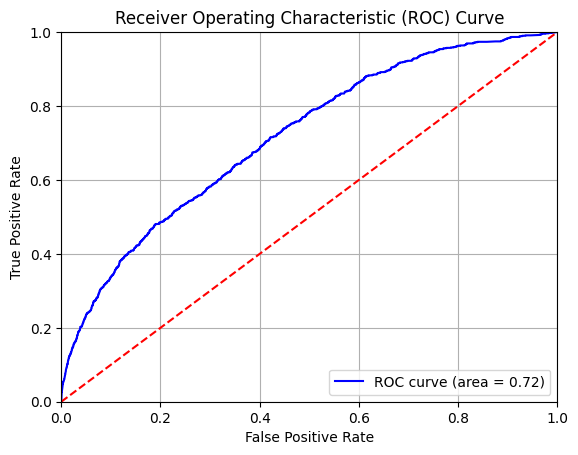

In [66]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred[:, 1])
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='blue', label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

In [67]:
ctb_pred = ctb_test[["user_id", "app_id", "rank"]]
ctb_pred["ctb_pred"] = y_pred[:, 1]
ctb_pred = ctb_pred.sort_values(by = ["user_id", "ctb_pred"], ascending = [True, False])
ctb_pred["ctb_rank"] = ctb_pred.groupby("user_id").cumcount() + 1
ctb_pred

,user_id,app_id,rank,ctb_pred,ctb_rank
1368154,171,562860,2,0.005340,1
1368153,171,1010750,1,0.004500,2
1368155,171,824600,3,0.003830,3
1368157,171,2320,5,0.002781,4
1368156,171,434050,4,0.002658,5
...,...,...,...,...,...
1177428,14305977,926140,2,0.003185,1
1177429,14305977,1216200,3,0.001979,2
1177430,14305977,761620,4,0.001490,3
1177427,14305977,594040,1,0.000788,4


In [68]:
global_test = global_test[global_test["user_id"].isin(lfm_train["user_id"].unique())]

In [69]:
lfm_prediction = pd.DataFrame({"user_id":global_test["user_id"].unique()})
known_items = lfm_train.groupby("user_id")["app_id"].apply(list).to_dict()

In [70]:
mapper = generate_lightfm_recs_mapper(
    model = lfm_model
    ,item_ids = all_cols
    ,known_items = known_items
    ,N = 40
    ,user_mapping = lightfm_mapping["users_mapping"]
    ,item_inv_mapping = lightfm_mapping["apps_inv_mapping"]
    ,num_threads = 20
)

In [71]:
lfm_prediction["app_id"] = lfm_prediction["user_id"].map(mapper)

In [72]:
lfm_prediction.shape

(66456, 2)

In [73]:
lfm_prediction.head()

,user_id,app_id
0,11519957,"[1397650, 1363430, 1345820, 553310, 450390, 85..."
1,13971658,"[356570, 474750, 496300, 1283220, 396750, 6653..."
2,3330568,"[965680, 219830, 1100260, 328080, 633030, 2245..."
3,5023834,"[39150, 329440, 21980, 9010, 2630, 261980, 203..."
4,12821922,"[513510, 1226470, 1013320, 325180, 570840, 237..."


In [74]:
lfm_prediction = lfm_prediction.explode("app_id")
lfm_prediction["rank"] = lfm_prediction.groupby("user_id").cumcount() + 1

In [75]:
lfm_prediction.head()

,user_id,app_id,rank
0,11519957,1397650,1
0,11519957,1363430,2
0,11519957,1345820,3
0,11519957,553310,4
0,11519957,450390,5


In [76]:
lfm_prediction = lfm_prediction.merge(games_df, on = "app_id", how = "inner")
lfm_prediction = lfm_prediction.drop(columns=["title", "mac", "linux", "steam_deck", "user_reviews", "price_original", "discount"])
lfm_prediction.head()

,user_id,app_id,rank,date_release,win,rating,positive_ratio,price_final
0,11519957,1397650,1,2021-05-27,True,Very Positive,91,9.99
1,11519957,1363430,2,2020-09-25,True,Very Positive,94,0.00
2,11519957,1345820,3,2021-07-15,True,Overwhelmingly Positive,95,24.99
3,11519957,553310,4,2018-10-24,True,Overwhelmingly Positive,97,19.99
4,11519957,450390,5,2016-04-05,True,Overwhelmingly Positive,95,0.00


In [77]:
lfm_prediction = lfm_prediction.merge(games_meta_df, on="app_id")

In [78]:
set(lfm_prediction.columns).difference(set(X_test.columns))

{'app_id', 'description', 'user_id'}

In [79]:
to_pred = lfm_prediction.drop(columns = ["app_id", "user_id", "description"])

In [80]:
y_pred = model.predict_proba(to_pred)

In [81]:
ctb_pred = lfm_prediction[["user_id", "app_id", "rank"]]
ctb_pred["ctb_pred"] = y_pred[:, 1]
ctb_pred = ctb_pred.sort_values(by = ["user_id", "ctb_pred"], ascending = [True, False])
ctb_pred["ctb_rank"] = ctb_pred.groupby("user_id").cumcount() + 1
ctb_pred

,user_id,app_id,rank,ctb_pred,ctb_rank
2247965,911,1178220,6,0.003886,1
2247962,911,415200,3,0.003197,2
2247987,911,673880,28,0.002960,3
2247971,911,490920,12,0.002954,4
2247997,911,324680,38,0.002730,5
...,...,...,...,...,...
1743414,14305845,842100,15,0.001205,36
1743433,14305845,1346070,34,0.000991,37
1743413,14305845,1389160,14,0.000927,38
1743435,14305845,1344350,36,0.000816,39


In [155]:
def get_recommendations(user_id, num_recs):
    print(f"На основе ваших предпочтений, можем порекомендовать вам следующие {num_recs} игр:\n")
    games_rec = ctb_pred[
    (ctb_pred["user_id"] == user_id) 
    & (ctb_pred["ctb_rank"] <= num_recs)
    ]["app_id"].to_list()
    games_info = games_df.set_index("app_id").join(games_meta_df)[["title", "description"]]
    for i in range(num_recs):
        print(f"{i+1}: Название игры: {games_info.loc[games_rec[i], 'title']},\nОписание игры: {games_info.loc[games_rec[i], 'description']}")
    return None

In [156]:
get_recommendations(ctb_pred["user_id"].sample(n=1).iloc[0], num_recs = 10)

На основе ваших предпочтений, можем порекомендовать вам следующие 10 игр:

1: Название игры: Grey Instinct,
Описание игры: In this cyberpunk 2D point-and-click adventure game, play as Grey, an amateur detective. Unravel the mystery by searching for clues, solving puzzles, talking to the mask-wearing residents of New Corium, and, if you have time, maybe go on a date!
2: Название игры: Super Robot Wars 30,
Описание игры: 30 years on, the battle for our world's future continues. Super Robot Wars is a tactical RPG that brings characters and robots from a variety of mecha anime together to battle their mutual foes.
3: Название игры: GOD EATER 3,
Описание игры: Set in a post-apocalyptic setting, it’s up to your special team of God Eaters to take down god-like monsters devastating the world. With an epic story, unique characters, and all new God Arcs and Aragami, the latest evolution in ACTION is here!
4: Название игры: Age of Wonders III,
Описание игры: Age of Wonders III is the long anticip